# Training SRVNet

In [1]:
from VAMPNet_SRVNet import *

## Input the featurized trajectories
trajs = np.load("./alanine_dipeptide_45pairwise_distances_100trajs_0.1ps.npy", allow_pickle=True).item()
trajs = [i for i in trajs.values()]

## Create the time-lagged dataset
past, future = TimeLaggedDataset(trajs=trajs, lagtime=10, normalize=False)

## Set the random seed to ensure the reproducible training(not necessary)
set_random_seed(42)

## Set the training data loader and validation data loader and decide the raito of split data
train_loader, validation_loader =  split_train_validate_data(pastdata=past, futuredata=future, validation_ratio=0.2, train_batchsize=100000)

## Set the available device for training(not necessary)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

## Set the architecture for neural network
network_lobe = torch.nn.Sequential(
    torch.nn.BatchNorm1d(45),
    torch.nn.Linear(45, 45), torch.nn.ELU(),
    torch.nn.Linear(45, 10), torch.nn.ELU(),
    torch.nn.Linear(10, 2)
)
network_lobe = network_lobe.to(device=device)

## Create the deep_projector object and do initialization
projector = deep_projector(network_type='SRVNet', lobe=network_lobe, epsilon=1e-6, learning_rate=1e-3, device=device)

## Modify the optimizer from the outside(not necessary)
projector.optimizer = torch.optim.Adam(network_lobe.parameters(), lr=5e-4, weight_decay=1e-5)

## Training the model
projector.fit(train_loader=train_loader, num_epochs=5, validation_loader=validation_loader)

## Do projection and transformation by the optimal model(not necessary)
output_trajs = projector.transform(data=trajs)

load data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.32it/s]


==>epoch=0, training process=20.00%, the training loss function=2.2956979274749756, eigenvalues:[0.9652822  0.60326463];
==>epoch=0, training process=20.00%, the validation loss function=2.296318531036377;
==>epoch=1, training process=40.00%, the training loss function=2.7184784412384033, eigenvalues:[0.968487  0.8834655];
==>epoch=1, training process=40.00%, the validation loss function=2.732970714569092;
==>epoch=2, training process=60.00%, the training loss function=2.9079809188842773, eigenvalues:[0.981789  0.9716333];
==>epoch=2, training process=60.00%, the validation loss function=2.9085750579833984;
==>epoch=3, training process=80.00%, the training loss function=2.922346830368042, eigenvalues:[0.98726094 0.9734797 ];
==>epoch=3, training process=80.00%, the validation loss function=2.922639846801758;
==>epoch=4, training process=100.00%, the training loss function=2.930602550506592, eigenvalues:[0.9902542 0.974679 ];
==>epoch=4, training process=100.00%, the validation loss fun

/tmp/ipykernel_1368872/1456274883.py:52: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(_x, _y, RC_G.transpose(),levels=15, colors='black', vmin=0, vmax=7, linewidth=.5)


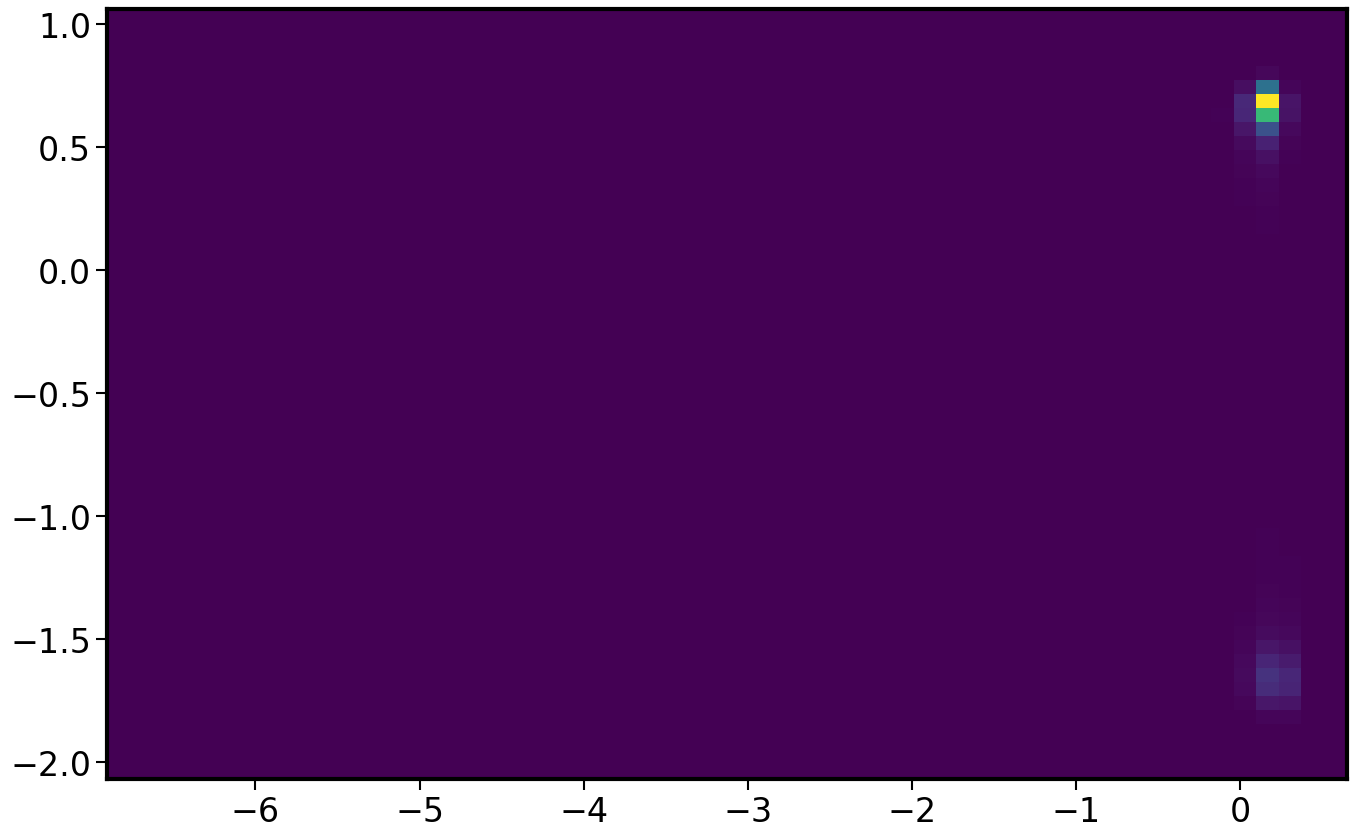

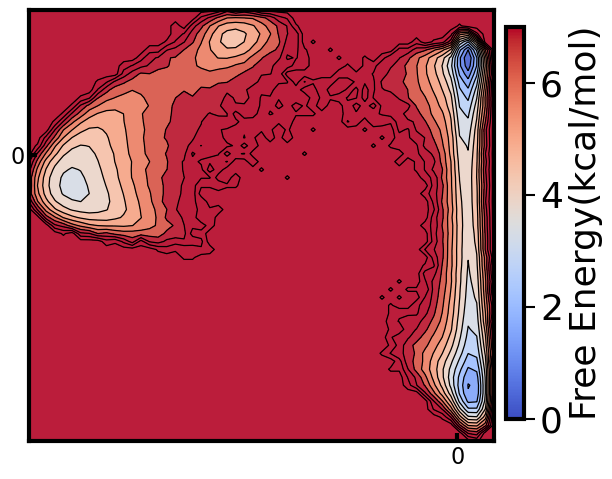

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
import pandas as pd
from tqdm import trange, tqdm
import matplotlib as mpl
%matplotlib inline

large = 54; med = 30; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'legend.title_fontsize':med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

from scipy.constants import Avogadro, Boltzmann, calorie_th
THERMO_CONSTANT = 10**-3 * Boltzmann * Avogadro / calorie_th

t = np.concatenate(output_trajs)
RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(t[:,0],t[:,1],bins=55)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)*THERMO_CONSTANT*300
RC_G=RC_G-np.nanmin(RC_G)

_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2

fig,ax = plt.subplots(figsize=(6, 5.6))
plt.contourf(_x, _y,RC_G.transpose(),levels=15, cmap='coolwarm', vmin=0, vmax=7, alpha=0.9)
plt.rcParams["lines.linewidth"]=0.9
plt.contour(_x, _y, RC_G.transpose(),levels=15, colors='black', vmin=0, vmax=7, linewidth=.5)
plt.tick_params(which='major', width=3, direction='in', labelsize=16, length=6)
plt.tick_params(which='minor', width=1, direction='in', length=0)
ax.xaxis.set_major_locator(MultipleLocator(60))
ax.yaxis.set_major_locator(MultipleLocator(60))
l = 0.92; b = 0.15; w = 0.03; h = 0.7
rect = [l, b, w, h]
cbar_ax = fig.add_axes(rect)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=7), cmap=plt.cm.coolwarm), cax=cbar_ax)
cb.ax.tick_params(labelsize=26)
cb.set_label('Free Energy(kcal/mol)',fontsize=26)
labels=cb.ax.get_xticklabels()

# Training VAMPNet by VAMP-2 Score

In [3]:
from VAMPNet_SRVNet import *

## Input the featurized trajectories
trajs = np.load("./alanine_dipeptide_45pairwise_distances_100trajs_0.1ps.npy", allow_pickle=True).item()
trajs = [i for i in trajs.values()][:20]

## Create the time-lagged dataset
past, future = TimeLaggedDataset(trajs=trajs, lagtime=10, normalize=False)

## Set the random seed to ensure the reproducible training(not necessary)
set_random_seed(42)

## Set the training data loader and validation data loader and decide the raito of split data
train_loader, validation_loader =  split_train_validate_data(pastdata=past, futuredata=future, validation_ratio=0.2, train_batchsize=10000)

## Set the available device for training(not necessary)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

## Set the architecture for neural network
## The output layer for VAMPNet must be softmax layer
network_lobe = torch.nn.Sequential(
    torch.nn.BatchNorm1d(45),
    torch.nn.Linear(45, 45), torch.nn.ReLU(),
    torch.nn.Linear(45, 20), torch.nn.ReLU(),
    torch.nn.Linear(20, 3),
    torch.nn.Softmax(dim=1)
)
network_lobe = network_lobe.to(device=device)

## Create the deep_projector object and do initialization
projector = deep_projector(network_type='VAMP2', lobe=network_lobe, epsilon=1e-6, learning_rate=1e-3, device=device)

## Modify the optimizer from the outside(not necessary)
projector.optimizer = torch.optim.Adam(network_lobe.parameters(), lr=1e-3, weight_decay=1e-6)

## Training the model
projector.fit(train_loader=train_loader, num_epochs=3, validation_loader=validation_loader)

## Do projection and transformation by the optimal model(not necessary)
output_trajs = projector.transform(data=trajs, instantaneous=True)

load data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.81it/s]


==>epoch=0, training process=33.33%, the training loss function=2.9420642852783203;
==>epoch=0, training process=33.33%, the validation loss function=2.7272379398345947;
==>epoch=1, training process=66.67%, the training loss function=2.9561901092529297;
==>epoch=1, training process=66.67%, the validation loss function=2.9143893718719482;
==>epoch=2, training process=100.00%, the training loss function=2.9603323936462402;
==>epoch=2, training process=100.00%, the validation loss function=2.860541582107544;


In [4]:
output_labels = []
for i in trange(len(output_trajs)):
    _labels = []
    for j in range(len(output_trajs[i])):
        _labels.append(np.argmax(output_trajs[i][j]))
    output_labels.append(np.array(_labels))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]


/tmp/ipykernel_1368872/2007006120.py:54: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(_x, _y, RC_G.transpose(),levels=15, colors='black', vmin=0, vmax=7, linewidth=.5)


Text(0, 0.5, '$\\psi$')

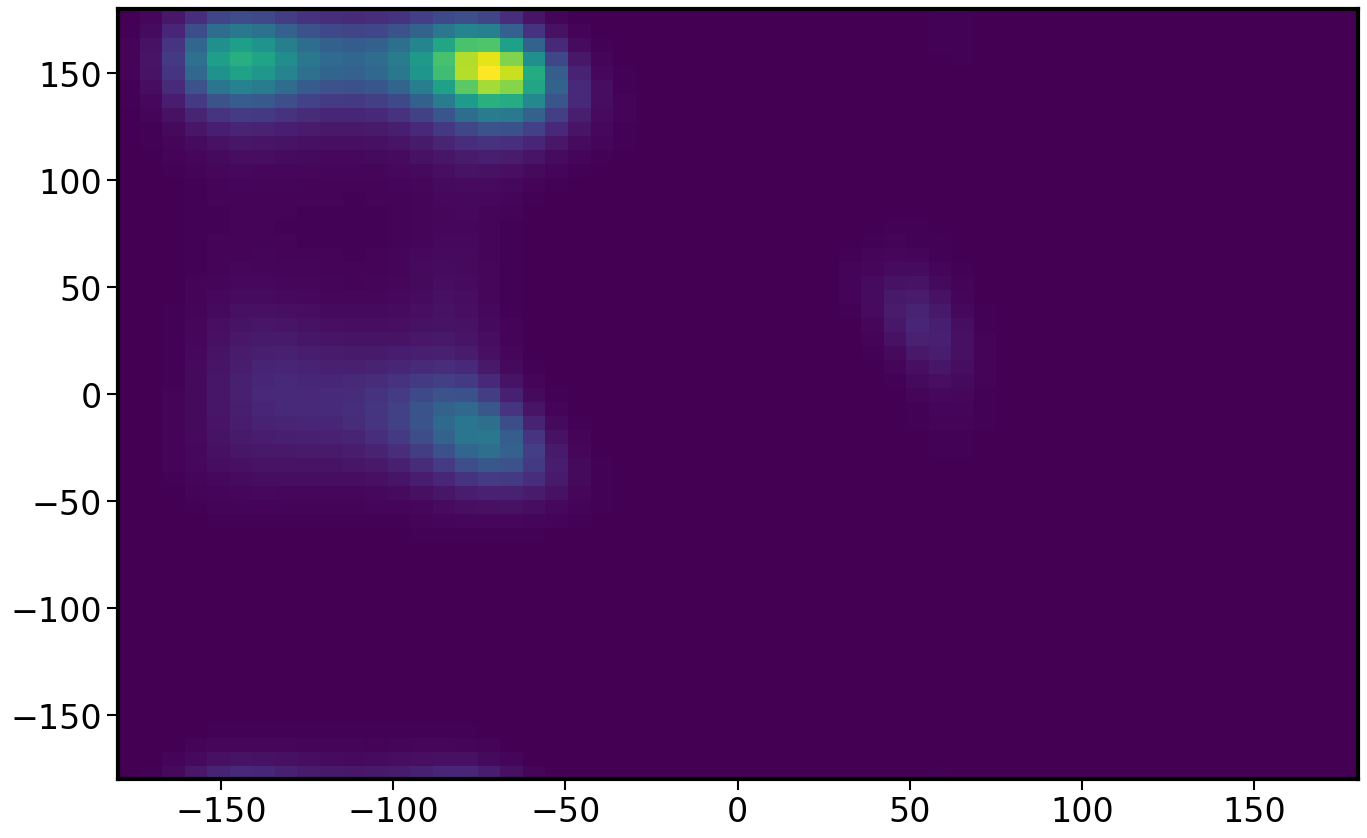

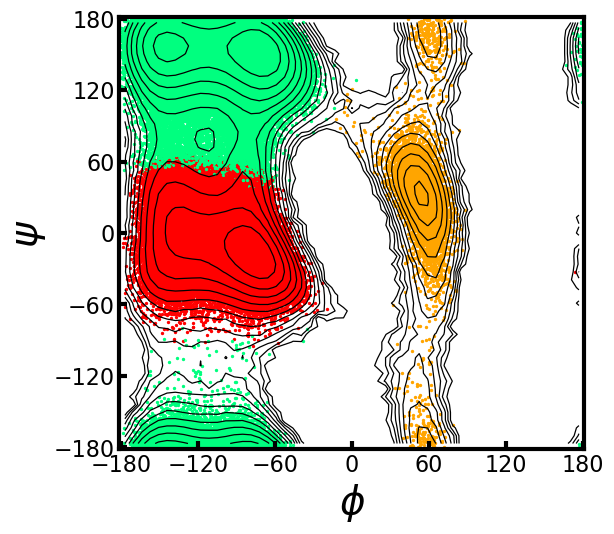

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
import pandas as pd
from tqdm import trange, tqdm
import matplotlib as mpl
%matplotlib inline

large = 54; med = 30; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'legend.title_fontsize':med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

angle = np.load("./alanine_dipeptide_phi_psi_ramachandran_angles_100trajs_0.1ps.npy", allow_pickle=True).item()
rama_angle =[i for i in angle.values()]
rama_angle= np.concatenate(rama_angle)

from scipy.constants import Avogadro, Boltzmann, calorie_th
THERMO_CONSTANT = 10**-3 * Boltzmann * Avogadro / calorie_th

RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(rama_angle[:,0],rama_angle[:,1],bins=55)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)*THERMO_CONSTANT*300
RC_G=RC_G-np.nanmin(RC_G)

_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2

fig,ax = plt.subplots(figsize=(6, 5.6))
plt.rcParams["lines.linewidth"]=0.9
plt.contour(_x, _y, RC_G.transpose(),levels=15, colors='black', vmin=0, vmax=7, linewidth=.5)
num_slice = 5
for i in range(len(output_labels)):
    plt.scatter(angle[i][output_labels[i]==0][::num_slice,0], angle[i][output_labels[i]==0][::num_slice,1], color='red', s=2)
    plt.scatter(angle[i][output_labels[i]==1][::num_slice,0], angle[i][output_labels[i]==1][::num_slice,1], color='orange', s=2)
    plt.scatter(angle[i][output_labels[i]==2][::num_slice,0], angle[i][output_labels[i]==2][::num_slice,1], color='springgreen', s=2)
    plt.scatter(angle[i][output_labels[i]==3][::num_slice,0], angle[i][output_labels[i]==3][::num_slice,1], color='deepskyblue', s=2)
plt.xlim(-181, 181)
plt.ylim(-181, 181)
plt.tick_params(which='major', width=3, direction='in', labelsize=16, length=6)
plt.tick_params(which='minor', width=1, direction='in', length=0)
ax.xaxis.set_major_locator(MultipleLocator(60))
ax.yaxis.set_major_locator(MultipleLocator(60))
plt.xlabel("$\\phi$",fontsize=28)
plt.ylabel("$\\psi$",fontsize=28)